In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Data Cleaning

In [6]:
df_clean = df.copy()
features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for feature in features:
    mask = df_clean["Outcome"] == 0

    feature_with_diabetes = df_clean.loc[~mask, feature]
    feature_without_diabetes = df_clean.loc[mask, feature]

    median_with_diabetes = feature_with_diabetes[feature_with_diabetes != 0].median().round()
    median_without_diabetes = feature_without_diabetes[feature_without_diabetes != 0 ].median().round()

    df_clean.loc[~mask & (df_clean[feature] == 0), feature] = median_with_diabetes
    df_clean.loc[mask & (df_clean[feature] == 0), feature] = median_without_diabetes
df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.378906,29.089844,141.690104,32.432682,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.104431,8.890820,89.197247,6.880709,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.000000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,170.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


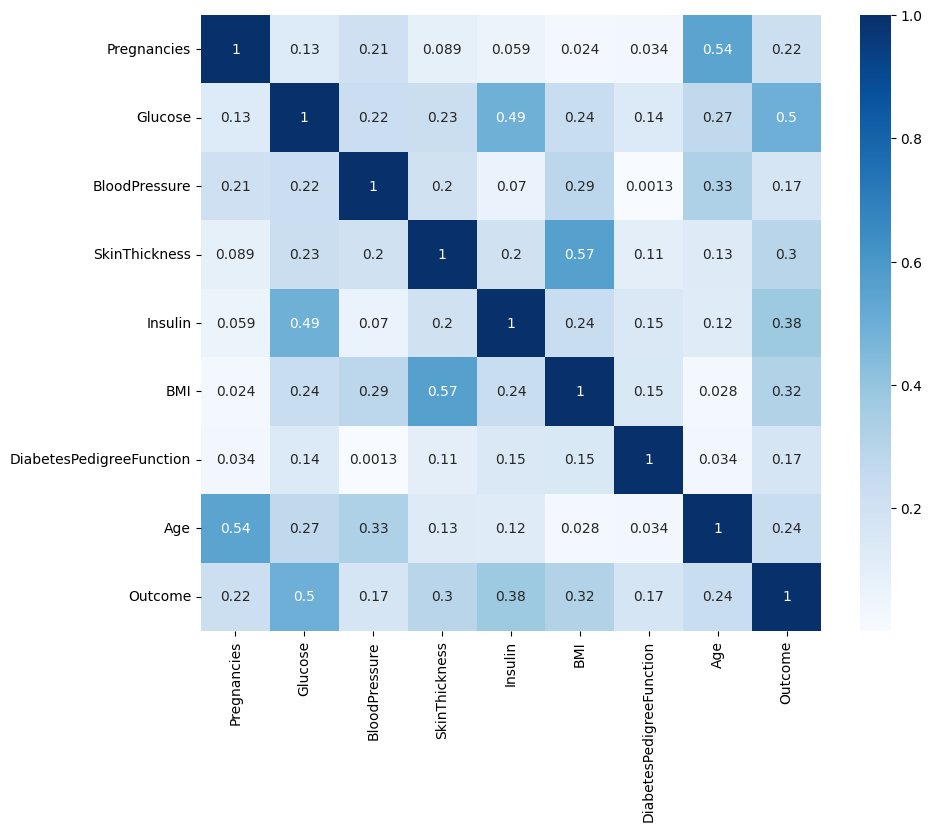

In [7]:
correlations = abs(df_clean.corr())
plt.figure(figsize = (10, 8))
sns.heatmap(correlations, annot=True, cmap="Blues")
plt.show()

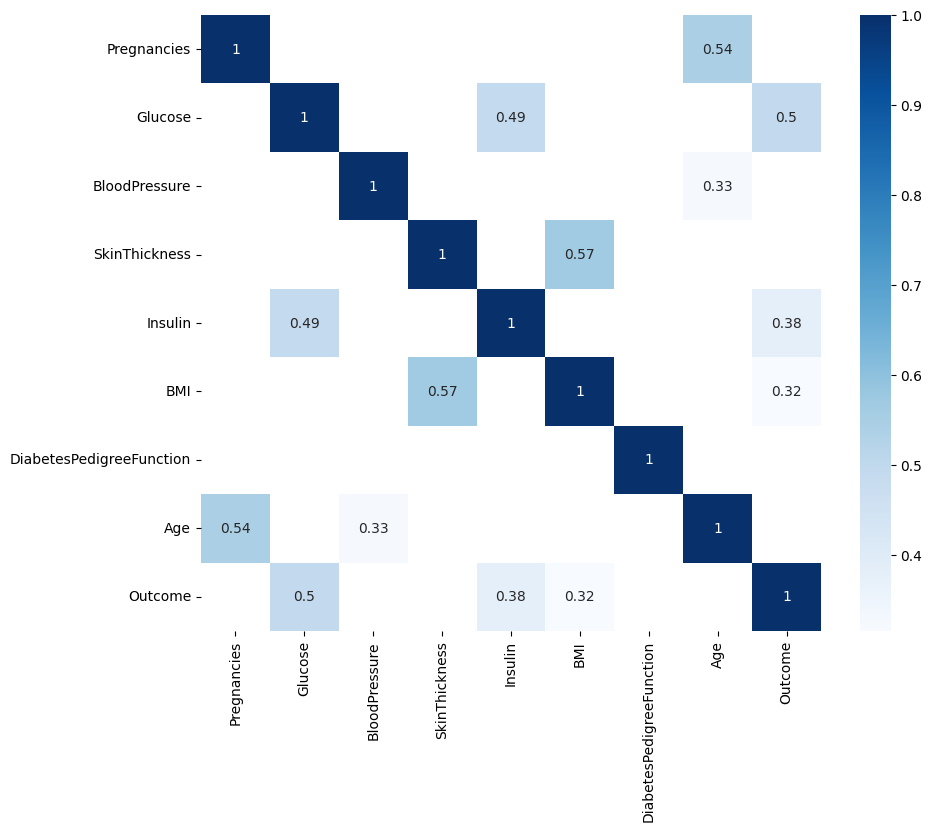

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlations[correlations >= 0.3], annot=True, cmap="Blues")
plt.show()

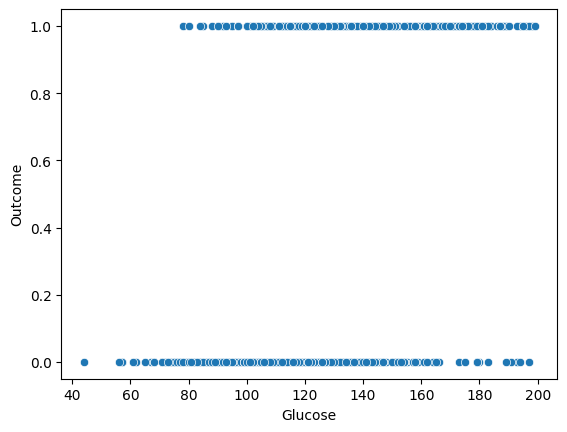

In [9]:
sns.scatterplot(data=df_clean, y="Outcome", x="Glucose")
plt.show()

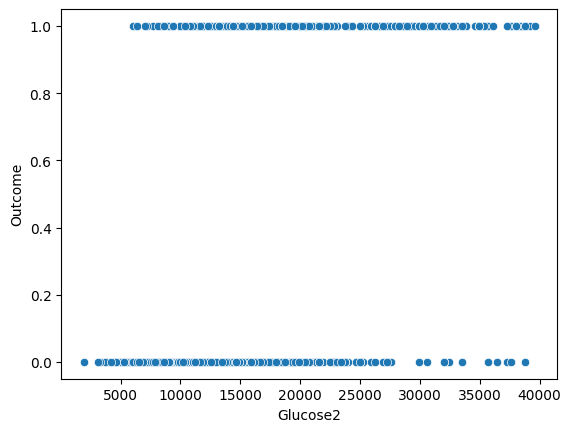

In [10]:
df_clean["Glucose2"] = df_clean["Glucose"] ** 2
sns.scatterplot(data=df_clean, y="Outcome", x="Glucose2")
plt.show()

# KNN

In [28]:
X = df_clean[["BMI", "Insulin", "Glucose2"]]
y = df_clean["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

grid_params = {
    "n_neighbors" : range(1, 20),
    "weights" : ["distance", "uniform"],
    "metric" : ["minkowski", "manhattan"],
    "p" : [1, 2]
}

model = KNeighborsClassifier()

knn_grid = GridSearchCV(model, grid_params, scoring="accuracy", cv=5)

knn_grid.fit(X_train_scaled, y_train)
print(f"Accuracy : %{knn_grid.best_score_ * 100:.2f}")
knn_grid.best_estimator_

Accuracy : %84.67


KNeighborsClassifier(n_neighbors=8, p=1, weights='distance')

In [29]:
prediction = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, prediction)
print(f"Accuracy : %{accuracy * 100:.2f}")

Accuracy : %86.21


# LOGISTIC REGRESSION

In [30]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [31]:
logreg_pred = logreg.predict(X_test_scaled)
logreg_accuracy = accuracy_score(y_test, logreg_pred)
print(f"Logistic Regression Accuracy: %{logreg_accuracy * 100:.2f}")

Logistic Regression Accuracy: %82.76


# Decision Trees

In [32]:
dtree = DecisionTreeClassifier()

grid_params = {
    "max_depth" : [3, 5, 10, None],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4],
}

dtree_grid = GridSearchCV(dtree, grid_params, scoring="accuracy", cv=5)
dtree_grid.fit(X_train_scaled, y_train)
print(f"Accuracy : %{dtree_grid.best_score_ * 100:.2f}")
dtree_grid.best_estimator_

Accuracy : %86.97


DecisionTreeClassifier(max_depth=3)

In [33]:
dtree_pred = dtree_grid.best_estimator_.predict(X_test_scaled)
dtree_accuracy = accuracy_score(y_test, dtree_pred)
print(f"Decision Tree Accuracy: %{dtree_accuracy * 100:.2f}")

Decision Tree Accuracy: %82.76


# Random Forest

In [34]:
grid_param = {
    'n_estimators': [10, 20, 30], 
    'max_features': ["log2", "sqrt", None],  
    'max_depth': [10, 20, 30, None],   
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4],     
    'bootstrap': [True, False]         
}

rf_model = RandomForestClassifier()

rf_grid = GridSearchCV(rf_model, grid_param, scoring="accuracy", cv=5)
rf_grid.fit(X_train_scaled, y_train)

print("Best Parameters:", rf_grid.best_params_)
best_rf_model = rf_grid.best_estimator_

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}


In [35]:
rf_prediction = best_rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_prediction)
print(f"Random Forest Accuracy: %{rf_accuracy * 100:.2f}")

Random Forest Accuracy: %86.21


# Naive Bayes

In [36]:

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

nb_predictions = nb_model.predict(X_test_scaled)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: %{nb_accuracy * 100:.2f}")


Naive Bayes Accuracy: %83.62


# SVM

In [37]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm_model = SVC()

svm_grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
svm_grid.fit(X_train_scaled, y_train)

print("Best Parameters:", svm_grid.best_params_)
best_svm_model = svm_grid.best_estimator_

Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [38]:
svm_prediction = best_svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_prediction)
print(f"Random Forest Accuracy: %{svm_accuracy * 100:.2f}")

Random Forest Accuracy: %85.34
